# Determining Feature Importances

This notebook is for exploring feature importance within a black box LSTM. I'll be starting with Permuation Importances and Shapley values.

### Building the Dataset

In [1]:
%cd ..
%cd .. 
%cd data

/Users/azel/github/Data-Science/jupyter_notebooks
/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/data


In [35]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys, glob
import matplotlib.pyplot as plt

from shap import DeepExplainer, summary_plot

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint 

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
%cd ..
%cd jupyter_notebooks/exploratory_modeling

/Users/azel/github/Data-Science
/Users/azel/github/Data-Science/jupyter_notebooks/exploratory_modeling


In [228]:
def tech_company_data(ticker):
    """
    Containes Tech Index
    """    
    dts = DailyTimeSeries(ticker)
    df = dts.initiate()
    with HiddenPrints():
        df = dts.add_securities(['XLK', 'vix', 'SPX'], primary_df=df)
        df = dts.add_technicals(['SMA', 'EMA', 'MACD', 'STOCH', 
                                   'RSI', 'ADX', 'CCI', 'BBANDS', 
                                   'AD', 'OBV'], 
                                  primary_df=df)
        df = dts.add_macro(primary_df=df, 
                             indices=['trade_index', 'longterm_rates'])
    
    return df

In [229]:
df = tech_company_data('AAPL')

################################################################### 
 Ticker:  AAPL 
 Last Refreshed:  2019-09-06 14:25:49 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


In [116]:
def get_target(df, target, time_shift=1):
    """
    Selects a target by shifting a specific column 
    by one timestep. Then seperates the training data 
    and target into X and y respectively. 
    
    ###############
    Parameters:
    ###############
    
    df: Timeseries dataframe created by fin_data
    target: percent_move or existing feature shifted by 
            timeshift.
    timeshift: number of timesteps to shift the feature by.
    
    """
    if target == 'percent_move':

        df['target'] = ((df['AAPL_adjusted_close'].shift(-1) -
                         df['AAPL_adjusted_close']) / 
                        (df['AAPL_adjusted_close']))*100
    
    elif target == 'abs_percent_move':
        
        df['target'] = np.abs(((df['AAPL_adjusted_close'].shift(-1) -
                                df['AAPL_adjusted_close']) / 
                               (df['AAPL_adjusted_close']))*100)

    else:

        df['target'] = df[target].shift(-time_shift)
        
    df = df.dropna()
    
    X = df.drop(columns='target').values
    y = df[['target']].values
    
    return X, y

In [117]:
X, y = get_target(df, 'AAPL_adjusted_close')

In [27]:
def prep_data(train_cut, val_cut, X=X, y=y):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [249]:
def extract_data(generator):
    for i in np.arange(len(generator)):
        if i == 0:
            a, b = generator[i]
        else: 
            c, d = generator[i]

            a = np.vstack((a, c))
            b = np.vstack((b, d))
            
    return a, b

In [28]:
X_train, X_test, X_val, y_train, y_test, y_val = prep_data(train_cut=.8,
                                                           val_cut=.6)

In [234]:
train_data_generator = TimeseriesGenerator(X_train, y_train, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=1)

test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=1)

val_data_generator = TimeseriesGenerator(X_val, y_val, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=1)

In [250]:
X_val_mod, y_val_mod = extract_data(val_data_generator)

In [44]:
model = Sequential()
model.add(LSTM(100, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights/{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history = model.fit_generator(train_data_generator, 
                              epochs = 200,
                              validation_data=test_data_generator,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/200
657/657 [==============================] - 22s 34ms/step - loss: 562.6979 - val_loss: 128.1469

Epoch 00001: val_loss improved from inf to 128.14686, saving model to weights/01-128.15.hdf5
Epoch 2/200
657/657 [==============================] - 18s 28ms/step - loss: 149.1842 - val_loss: 2682.9045

Epoch 00002: val_loss did not improve from 128.14686
Epoch 3/200
657/657 [==============================] - 18s 28ms/step - loss: 203.4428 - val_loss: 9880.8393

Epoch 00003: val_loss did not improve from 128.14686
Epoch 4/200
657/657 [==============================] - 18s 28ms/step - loss: 196.5487 - val_loss: 338.4254

Epoch 00004: val_loss did not improve from 128.14686
Epoch 5/200
657/657 [==============================] - 18s 28ms/step - loss: 85.9011 - val_loss: 552.2015

Epoch 00005: val_loss did not improve from 128.14686
Epoch 6/200
657/657 [==============================] - 18s 27ms/step - loss: 99.8352 - val_loss: 496.6329

Epoch 00006: val_loss did not improve from 128.

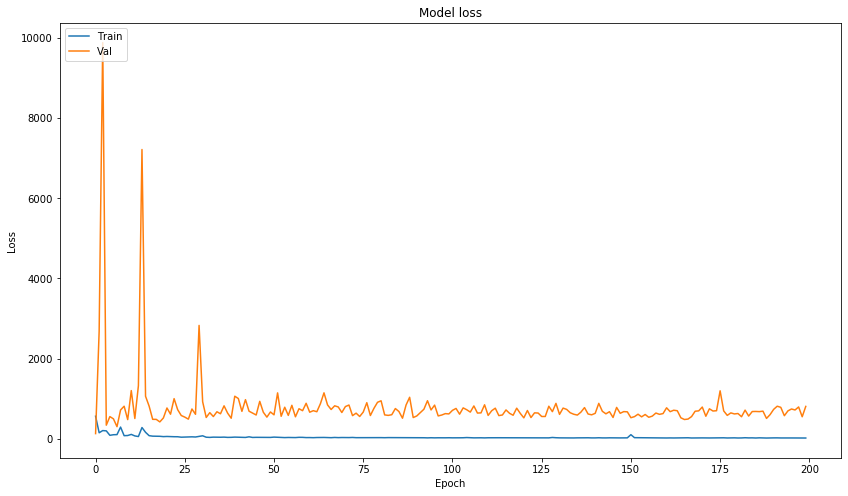

In [45]:
# Plot training & validation loss values
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

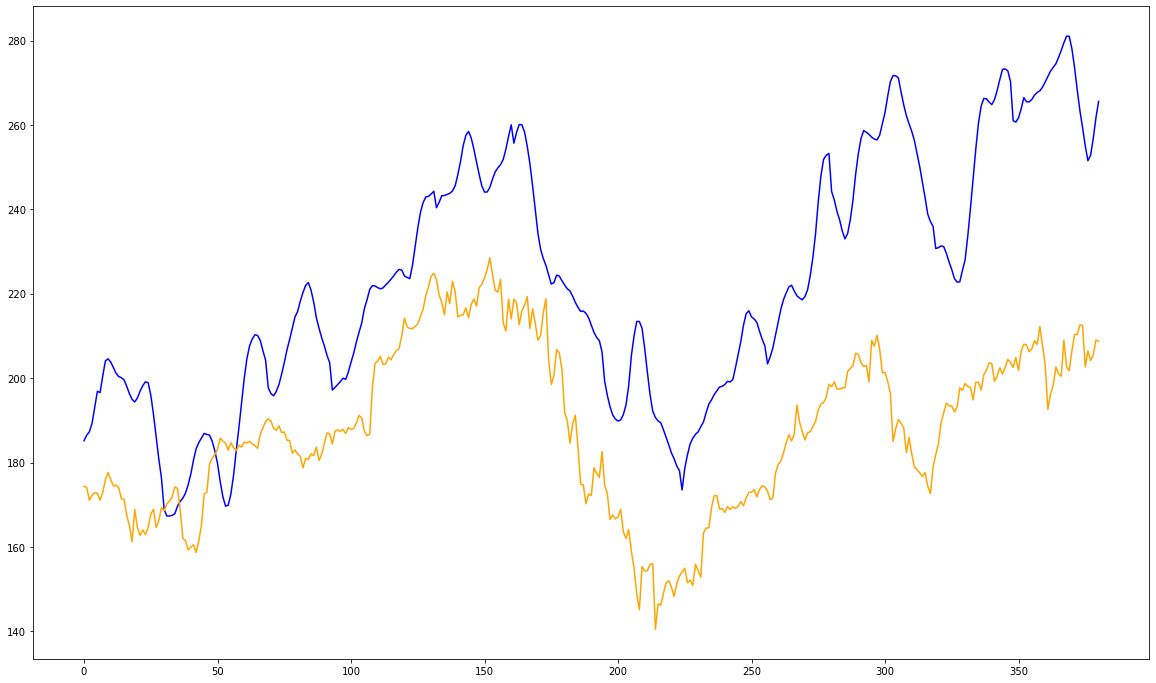

In [252]:
list_of_files = glob.glob('weights/*.hdf5') 
latest_file = max(list_of_files, key=os.path.getctime)

model.load_weights(latest_file)

model.compile(optimizer='adam', loss='mse')

y_pred = model.predict_generator(val_data_generator)

plt.figure(figsize=(20,12))

plt.plot(y_pred, color='blue')
plt.plot(y_val_mod, color='orange');

In [290]:
de = DeepExplainer(model = model, data=X_val_mod)

In [299]:
shaps_vals = de.shap_values(X_val_mod)

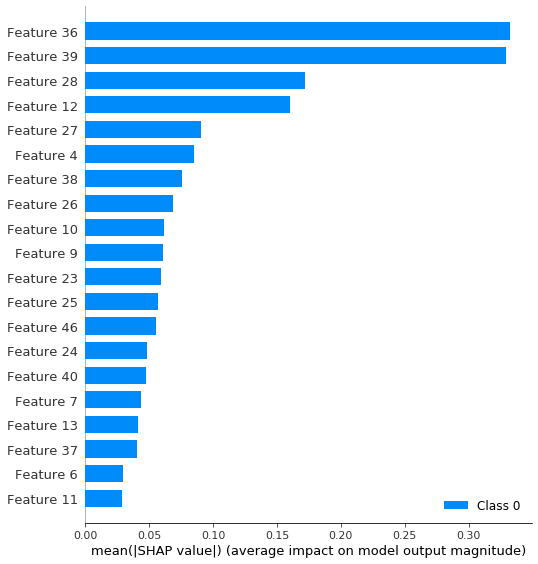

In [557]:
summary_plot([shaps_vals[0][100]])

In [539]:
def individual_array(sample):
    
    # get the means for each sampling
    for i in np.arange(len(sample[0])):
        means = []
        for j in np.arange(len(sample)):
            means.append(sample[j][i])
        s_value = np.array(np.mean(means))

        if i == 0:
            final_array = s_value
        else:
            final_array = np.hstack((final_array, s_value))
            
    return final_array


In [541]:
def flatten_shap_values(shap_vals):
    
    #Pull the array out of the list. 
    sv = shap_vals[0]
    
    count = 0
    for sample in sv: 
        sample_array = individual_array(sample)
        if count == 0:
            final_array = sample_array
        else:
            final_array = np.vstack((final_array, sample_array))
        
        count +=1
        
    return final_array
    

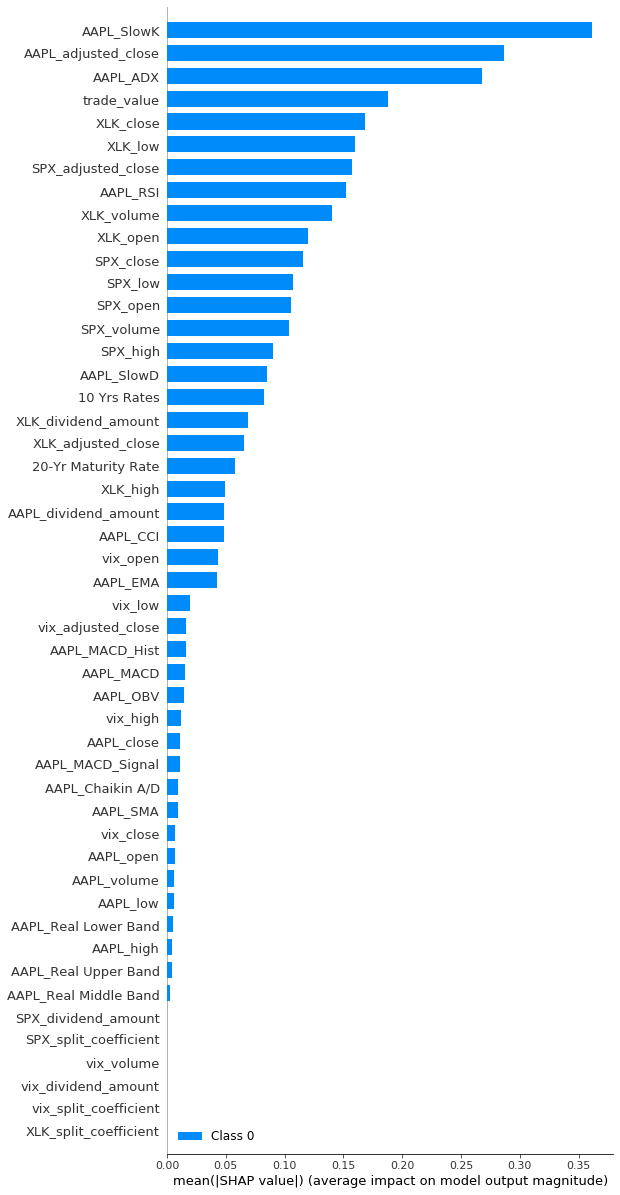

In [549]:
summary_plot([flatten_shap_values(shaps_vals)], feature_names=df.columns, max_display=49)

In [547]:
??summary_plot

Signature:
summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    auto_size_plot=True,
    layered_violin_max_num_bins=20,
    class_names=None,
)
Source:   
def summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None,
                 color=None, axis_color="#333333", title=None, alpha=1, show=True, sort=True,
                 color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20, class_names=None):
    """Create a SHAP summary plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    features : numpy.array o